#### Author: Gioele Eterno

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
#from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# Classification

## Data Preparation
- prepare your data for the classification task
- decide a categorical variable to predict (`outcome_type` is the most natural for this dataset)
    - the target variable should transformed to numerical (0, 1, 2 ...)
- remove all the variable that are not necessary or "leak" information about your target.
- divide the dataset in train/test
- for each classifier perform the correct preprocessing.

As always let's read the dataset returned by the first notebook of this project:

In [3]:
df = pd.read_csv('aac_dogs_01.csv')
df.head()

,date_of_birth,outcome_subtype,outcome_type,sex_upon_outcome,outcome_datetime,breed,color,intake_condition,intake_type,sex_upon_intake,...,playfulness,protectiveness,trainability,energy,barking,breed_type,top6_breeds,age_upon_intake,age_upon_outcome,length_of_stay
0,2017-03-08,Foster,Adoption,Intact Male,2017-05-09 07:48:00,Greyhound Mix,Tan,Normal,Stray,Intact Male,...,3.191688,3.390986,2.873580,4.167703,1.974363,mix,False,0.084932,0.169863,0.082192
1,2016-07-03,Foster,Adoption,Spayed Female,2016-09-10 17:22:00,Boxer Mix,Brown/White,Normal,Stray,Intact Female,...,3.916796,3.144705,3.010407,4.231642,2.737943,mix,False,0.101370,0.189041,0.087671
2,2010-02-10,Partner,Transfer,Intact Male,2018-03-01 16:27:00,Chihuahua Shorthair Mix,Red,Normal,Stray,Intact Male,...,3.577027,3.620172,1.832087,2.834511,5.015286,mix,True,8.043836,8.057534,0.013699
3,2006-10-22,Partner,Transfer,Neutered Male,2015-10-28 14:12:00,Pomeranian Mix,White/Black,Normal,Stray,Intact Male,...,2.203599,3.770284,3.482516,2.037904,3.420557,mix,False,9.005479,9.021918,0.016438
4,2016-09-07,Partner,Transfer,Spayed Female,2017-09-16 16:01:00,Shih Tzu Mix,White/Brown,Normal,Stray,Spayed Female,...,3.094009,2.924166,4.698562,2.944130,2.754888,mix,False,1.013699,1.024658,0.010959


In [4]:
df['outcome_type'].value_counts()

outcome_type
Transfer           2797
Adoption            919
Euthanasia          452
Return to Owner     160
Died                 37
Missing               7
Disposal              1
Rto-Adopt             1
Name: count, dtype: int64

As suggested the aim is to predict the `outcome_type` of the dog. To do that let's map the various attribute values into integers as follows:

In [5]:
outcome_dict = {
    'Transfer' : 0,
    'Adoption' : 1,
    'Euthanasia' : 2,
    'Return to Owner' : 3,
    'Died' : 2,
    'Missing' : 2,
    'Disposal' : 2,
    'Rto-Adopt' : 1
}

Essentially label $0$ stands for `Transfer`, $1$ for an adoption type of outcome (i.e. `Adoption` and `Rto-Adopt`), $2$ for a 'bad' outcome (i.e. `Euthanasia`, `Died`, `Missing`, `Disposal`) and eventually $3$ for `Return to Owner`.

In [6]:
y = df['outcome_type'].map(outcome_dict)

The less frequent class is $3$ i.e. `Return to Owner`:

In [7]:
y.value_counts()

outcome_type
0    2797
1     920
2     497
3     160
Name: count, dtype: int64

Equivalently in percentage is:

In [8]:
y.value_counts().div(y.value_counts().sum())*100

outcome_type
0    63.946045
1    21.033379
2    11.362597
3     3.657979
Name: count, dtype: float64

In [9]:
df.columns

Index(['date_of_birth', 'outcome_subtype', 'outcome_type', 'sex_upon_outcome',
       'outcome_datetime', 'breed', 'color', 'intake_condition', 'intake_type',
       'sex_upon_intake', 'intake_datetime', 'breed_avg_life_expectancy',
       'breed_avg_height', 'breed_avg_weight', 'good_with_children',
       'good_with_other_dogs', 'shedding', 'grooming', 'drooling',
       'coat_length', 'good_with_strangers', 'playfulness', 'protectiveness',
       'trainability', 'energy', 'barking', 'breed_type', 'top6_breeds',
       'age_upon_intake', 'age_upon_outcome', 'length_of_stay'],
      dtype='object')

Now the next step to do is to choose the attributes over which the models will be trained together with the class to predict `outcome_type`.

At first I decided to consider the following attributes: '`sex_upon_outcome`', '`breed`', '`color`', '`intake_condition`', '`intake_type`', '`breed_avg_life_expectancy`', '`breed_avg_height`', '`breed_avg_weight`', '`good_with_children`', '`good_with_other_dogs`', '`shedding`', '`grooming`', '`drooling`', '`coat_length`', '`good_with_strangers`', '`playfulness`', '`protectiveness`', '`trainability`', '`energy`', '`barking`', '`age_upon_outcome`', '`length_of_stay`' ('`sex_upon_intake`' was excluded since it should have a minor role than '`sex_upon_outcome`' when considering the '`outcome_type`').

The main difficulty to overcome with this selection is to correctly encode the categorical variables into numerical ones. The most natural ones could be either a label encoding or a one-hot encoding. This two approaches though can be somewhat problematic for different reasons. Firstly, both encoding can lead to correlations between otherwise uncorrelated variables. Secondly the label encoding it's more suitable for ordinal attributes since it preserves the ordering information. Thirdly the one-hot encoding approach can lead to the curse of dimensionality since especially in the `breed` and in the `color` case there are hundreds and hundreds of different values. 

I found a possible solution in the following article [link](https://letsdatascience.com/frequency-encoding/) in which the 'Frequency encoding' is explained. The core idea is to label each value of a categorical attribute with its frequency. This approach reduces the possibility of spurious correlations and of course prevents the curse of dimensionality. Moreover the problem of ordering non ordinal attribute (which is related to label encoding) here can be more naturally solved by using an order based on the frequency which gives to the models an idea of the weight of each value.

By doing this operation we can anticipate here that exploiting the `.feature_importances_` attribute of the Decision Tree classifier, the more relevant variables in the classification will be '`sex_upon_outcome`', '`age_upon_outcome`', '`intake_condition`', '`intake_type`', '`length_of_stay`'.

Let's define both lists `columns` and `columns2keep` that represent respectively all the columns considered at first and then the most relevant ones.

In [10]:
columns = ['breed_avg_life_expectancy', 'breed_avg_height', 'breed_avg_weight',
       'good_with_children', 'good_with_other_dogs', 'shedding', 'grooming',
       'drooling', 'coat_length', 'good_with_strangers', 'playfulness',
       'protectiveness', 'trainability', 'energy', 'barking','age_upon_outcome', 'length_of_stay',
       'sex_upon_outcome', 'breed', 'color', 'intake_condition', 'intake_type']

In [11]:
columns2keep = ['age_upon_outcome', 'length_of_stay','sex_upon_outcome', 'intake_condition', 'intake_type']

In order to prevent data leakage we first split into train and test and then encode on the training set. The encoding on the test set is done by using the encoding of the training set.

So we first split into train and test the quantitities `df[columns]`-`y` and `df[columns2keep]`-`y` respectively:

In [12]:
df_train, df_test, y_train, y_test = train_test_split(df[columns], y, 
                                                    test_size=0.3, 
                                                    random_state=0,
                                                    stratify=y
                                                   )

In [13]:
df2k_train, df2k_test, y_train, y_test = train_test_split(df[columns2keep], y, 
                                                    test_size=0.3, 
                                                    random_state=0,
                                                    stratify=y
                                                   )

Then we perform the actual frequency encoding on the training set:

In [14]:
df_train['sex_upon_outcome_encoded'] = df_train['sex_upon_outcome'].map(df_train['sex_upon_outcome'].value_counts())
df_train['breed_encoded'] = df_train['breed'].map(df_train['breed'].value_counts())
df_train['color_encoded'] = df_train['color'].map(df_train['color'].value_counts())
df_train['intake_condition_encoded'] = df_train['intake_condition'].map(df_train['intake_condition'].value_counts())
df_train['intake_type_encoded'] = df_train['intake_type'].map(df_train['intake_type'].value_counts())

In [15]:
df2k_train['sex_upon_outcome_encoded'] = df2k_train['sex_upon_outcome'].map(df2k_train['sex_upon_outcome'].value_counts())
df2k_train['intake_condition_encoded'] = df2k_train['intake_condition'].map(df2k_train['intake_condition'].value_counts())
df2k_train['intake_type_encoded'] = df2k_train['intake_type'].map(df2k_train['intake_type'].value_counts())

and on the test set. Notice that the test set categorical attributes are mapped by using the training set ones. In case of missing values (i.e. attribute values that are present in the training set but not in the test set) then the encoding of such values is done by using the minimum frequency value for that attribute

In [16]:
df_test['sex_upon_outcome_encoded'] = df_test['sex_upon_outcome'].map(df_train['sex_upon_outcome'].value_counts()).fillna(df_train['sex_upon_outcome'].value_counts().min())
df_test['breed_encoded'] = df_test['breed'].map(df_train['breed'].value_counts()).fillna(df_train['breed'].value_counts().min())
df_test['color_encoded'] = df_test['color'].map(df_train['color'].value_counts()).fillna(df_train['color'].value_counts().min())
df_test['intake_condition_encoded'] = df_test['intake_condition'].map(df_train['intake_condition'].value_counts()).fillna(df_train['intake_condition'].value_counts().min())
df_test['intake_type_encoded'] = df_test['intake_type'].map(df_train['intake_type'].value_counts()).fillna(df_train['intake_type'].value_counts().min())

In [17]:
df2k_test['sex_upon_outcome_encoded'] = df2k_test['sex_upon_outcome'].map(df2k_train['sex_upon_outcome'].value_counts()).fillna(df2k_train['sex_upon_outcome'].value_counts().min())
df2k_test['intake_condition_encoded'] = df2k_test['intake_condition'].map(df2k_train['intake_condition'].value_counts()).fillna(df2k_train['intake_condition'].value_counts().min())
df2k_test['intake_type_encoded'] = df2k_test['intake_type'].map(df2k_train['intake_type'].value_counts()).fillna(df2k_train['intake_type'].value_counts().min())

After the encoding we can drop the original non-encoded attributes:

In [18]:
df_train = df_train.drop(columns = ['sex_upon_outcome', 'breed', 'color', 'intake_condition', 'intake_type'])
df_test = df_test.drop(columns = ['sex_upon_outcome', 'breed', 'color', 'intake_condition', 'intake_type'])

In [19]:
df2k_train = df2k_train.drop(columns = ['sex_upon_outcome', 'intake_condition', 'intake_type'])
df2k_test = df2k_test.drop(columns = ['sex_upon_outcome', 'intake_condition', 'intake_type'])

In the following cells of this section we define the variables `X` and `X2k` (train and test for both) which contain the numerical values of the attributes considered above. Then we normalize beween $0$ and $1$ by using `MinMaxScaler()` (the normalization is relevant for those classifiers that compare different attributes like the Nearest Neighbor classifier).
When normalizing it's important to use `fit_transform` only on the training set and simply `transform` on the test set since the test set is a black box for us (and we don't want data leakage).

In [20]:
X_train = df_train.values
X_train[:1]

array([[1.25000000e+01, 2.15000000e+01, 6.00000000e+01, 3.83797185e+00,
        6.50028842e-01, 2.03692649e+00, 2.09687473e+00, 2.10978996e+00,
        1.98061559e+00, 4.46246651e+00, 3.46164005e+00, 3.22671313e+00,
        4.79333583e+00, 4.31900418e+00, 2.54011152e+00, 8.98630137e-01,
        6.02739726e-02, 1.01700000e+03, 5.00000000e+02, 4.60000000e+01,
        2.54400000e+03, 2.03300000e+03]])

In [21]:
X_test = df_test.values
X_test[:1]

array([[1.22500000e+01, 2.52500000e+01, 8.12500000e+01, 2.49835911e+00,
        3.04609867e+00, 3.85359265e+00, 2.63359408e-01, 1.58704619e+00,
        9.96645598e-01, 1.94032130e+00, 4.27793153e+00, 4.45184168e+00,
        4.24861587e+00, 4.09382814e+00, 1.65291871e+00, 1.91780822e-01,
        5.47945205e-03, 1.01700000e+03, 1.00000000e+00, 3.50000000e+01,
        2.54400000e+03, 7.97000000e+02]])

In [22]:
X2k_train = df2k_train.values
X2k_train[:1]

array([[8.98630137e-01, 6.02739726e-02, 1.01700000e+03, 2.54400000e+03,
        2.03300000e+03]])

In [23]:
X2k_test = df2k_test.values
X2k_test[:1]

array([[1.91780822e-01, 5.47945205e-03, 1.01700000e+03, 2.54400000e+03,
        7.97000000e+02]])

In [24]:
minmaxscaler = MinMaxScaler()

In [25]:
X_train = minmaxscaler.fit_transform(X_train)
X_test = minmaxscaler.transform(X_test)

In [26]:
X2k_train = minmaxscaler.fit_transform(X2k_train)
X2k_test = minmaxscaler.transform(X2k_test)

## Dummy
It's always a good idea to understand how well a naive model performs. You can use the DummyClassifier for that. If your next model do worse than naive... well, you may have a problem!

The dummy classifier classifies everything as the most frequent class

In [27]:
from sklearn.dummy import DummyClassifier

In [28]:
dummy_clf = DummyClassifier()

In [29]:
dummy_clf.fit(X_train, y_train)

DummyClassifier()

In [30]:
y_pred_dummy = dummy_clf.predict(X_test)

In [31]:
print(classification_report(y_test, y_pred_dummy, digits=4))

              precision    recall  f1-score   support

           0     0.6398    1.0000    0.7803       840
           1     0.0000    0.0000    0.0000       276
           2     0.0000    0.0000    0.0000       149
           3     0.0000    0.0000    0.0000        48

    accuracy                         0.6398      1313
   macro avg     0.1599    0.2500    0.1951      1313
weighted avg     0.4093    0.6398    0.4992      1313



c:\Users\gioel\anaconda3\envs\env_master_2025\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gioel\anaconda3\envs\env_master_2025\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gioel\anaconda3\envs\env_master_2025\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

From the `classification_report` above we see that by classifying everything as the most frequent class ($0$ in our case) we obtain an accuracy of $0.6398$. Therefore to evaluate the goodness of every other classifier, we want them to have an higher accuracy then this thershold.

## Decision Tree
- find the best parameters
- evaluate the performance of your model (with the correct metrics and plots)
- plot the decision tree and try to interpret it. Which are the most important features?

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

The first classifier to test is the Decision Tree classifier. The key problem to overcome is to choose the correct parameters.

A possible way to approach this problem is to manually vary the hyper-parameters and, for example, calculating how the accuracy score changes on both the train set and the test set. This procedure helps us to avoid overfitting (high accuracy on the train set but low on the test set). Let's do this to determine the best value for the hyper-parameter `max_depth`.

In [33]:
max_depth_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, None]

accuracy_list_train = list()
accuracy_list_test = list()

for max_depth in max_depth_list:
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
    clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    
    accuracy_list_test.append(accuracy_score(y_test, y_pred_test))
    accuracy_list_train.append(accuracy_score(y_train, y_pred_train))

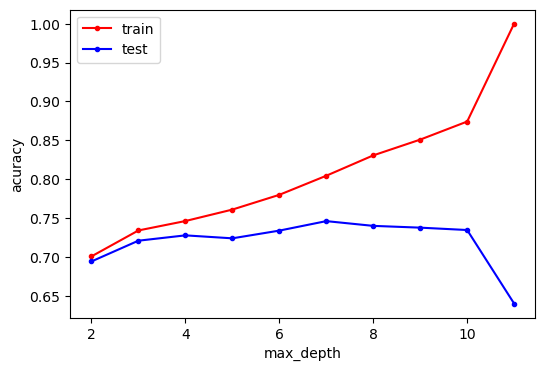

In [34]:
plt.figure(figsize=(6, 4))
max_depth_list_plot = np.arange(2, 12)
plt.plot(max_depth_list_plot, accuracy_list_train, label='train', marker='.', c='r')
plt.plot(max_depth_list_plot, accuracy_list_test, label='test', marker='.', c='b')

plt.ylabel('acuracy')
plt.xlabel('max_depth')
plt.legend()
plt.show()

As can be seen above lower values of `max_depth` are to be preferred since the gap in accuracy between train and test set is smaller.

This manual procedure of finding the best hyper-parameters can be quite intensive to do. Luckily it can be automatized by using `GridSearchCV` and/or `RandomizedSearchCV`.

The following is an example of usage of `RandomizedSearchCV` to find the best hyper-parameters for the Decision Tree classifier among the ones listed in the `param_distr` dictionary.

`RandomizedSearchCV` in this case takes the following parameters: 

- `cv` $= 10$: a cross-validation is applied on the training set by splitting it in $10$ parts and iteratively using $9$ parts for training and $1$ for test;
- `n_iter` $= 250$: Among all possible parameter combinations, $250$ random combination of them are tested;
- `scoring` $=$ 'f1_micro': The model performance during cross-validation are evaluated according to the f1-score (we want to have a low number of both false positives and false negatives). The term `micro` refers to micro-averaging and is useful when class imbalance exists (as in our case) because it gives equal weight to each instance rather than each class.
- `n_jobs` $= 8$: The calculation is runned in parallel on $8$ processors

In [35]:
param_distr = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None],
    'min_samples_split': [2, 5, 10, 20, 50], 
    'min_samples_leaf': [1, 3, 5, 10, 20], 
    'min_impurity_decrease': [0.0, 0.001, 0.01, 0.1, 0.2],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.1, 0.2, 1],
}

tree_clf = DecisionTreeClassifier(random_state=0)

rs = RandomizedSearchCV(tree_clf, param_distributions=param_distr, cv=10, 
                        n_iter=250,
                        scoring='f1_micro',
                        n_jobs=8
                       )
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=0),
                   n_iter=250, n_jobs=8,
                   param_distributions={'ccp_alpha': [0.0, 0.001, 0.01, 0.1,
                                                      0.2, 1],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, None],
                                        'min_impurity_decrease': [0.0, 0.001,
                                                                  0.01, 0.1,
                                                                  0.2],
                                        'min_samples_leaf': [1, 3, 5, 10, 20],
                                        'min_samples_split': [2, 5, 10, 20,
                                                              50]},
                   scoring='f1_micro')

The following are the result of the `RandomizedSearchCV` above:

In [36]:
best_tree_clf = rs.best_estimator_
rs.best_params_

{'min_samples_split': 50,
 'min_samples_leaf': 1,
 'min_impurity_decrease': 0.001,
 'max_depth': 6,
 'criterion': 'gini',
 'ccp_alpha': 0.0}

This choice of hyper-parameters leads to the `classification_report` of the next cell:

In [37]:
y_pred_tree = best_tree_clf.predict(X_test)
print(classification_report(y_test, y_pred_tree, digits=4))

              precision    recall  f1-score   support

           0     0.7305    0.9488    0.8255       840
           1     0.7574    0.4638    0.5753       276
           2     0.8276    0.1611    0.2697       149
           3     0.7500    0.3750    0.5000        48

    accuracy                         0.7365      1313
   macro avg     0.7664    0.4872    0.5426      1313
weighted avg     0.7479    0.7365    0.6979      1313



The result are better than the Dummy classifier since the accuracy is higher and an interesting thing is that this classifier is able to recognize the class $3$ with a quite high precision. The results for the recall are not particularly exciting but considering that class $3$ represents less than $4\%$ of the whole `outcome_type`, it was to be expected that such class could have been difficult to predict. A worse result is obtained for class $2$ (which covers the $11\%$ of the `outcome_type`) which in this case is the most difficult to predict.

Let's have a look at the confusion matrix:

In [38]:
cm_tree = confusion_matrix(y_test, y_pred_tree)
cm_tree

array([[797,  36,   5,   2],
       [148, 128,   0,   0],
       [117,   4,  24,   4],
       [ 29,   1,   0,  18]], dtype=int64)

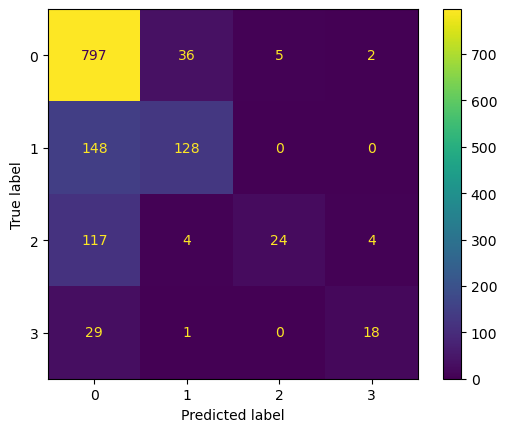

In [39]:
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree)
disp_tree.plot()
plt.show()

As expected (because of the low recall) there is an high number of false negatives both for class $2$ and class $3$.

Visually the top of the tree looks like this:

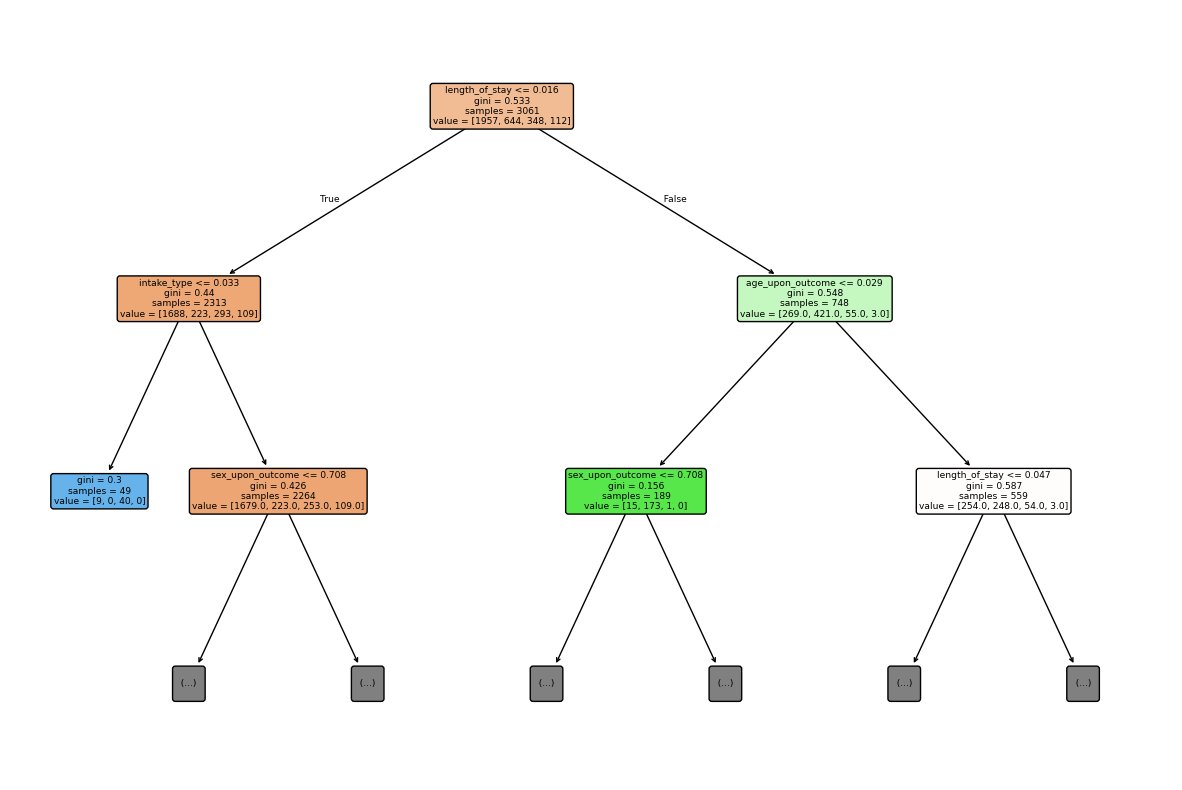

In [40]:
plt.figure(figsize=(15, 10))
plot_tree(best_tree_clf, feature_names=columns, 
          filled=True, rounded=True, impurity=True, max_depth=2
         )
plt.show()

Now we exploit an important characteristic of the Decision Tree classifier which is the ability to estimate the importance of the features passed in the training set by using the `feature_importances_` attribute:

In [41]:
best_tree_clf.feature_importances_

array([0.        , 0.        , 0.        , 0.00962044, 0.02211447,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00669012, 0.01166341, 0.01025438, 0.00616918,
       0.1873193 , 0.48384121, 0.08633938, 0.01694027, 0.00666743,
       0.02765909, 0.12472131])

and visually:

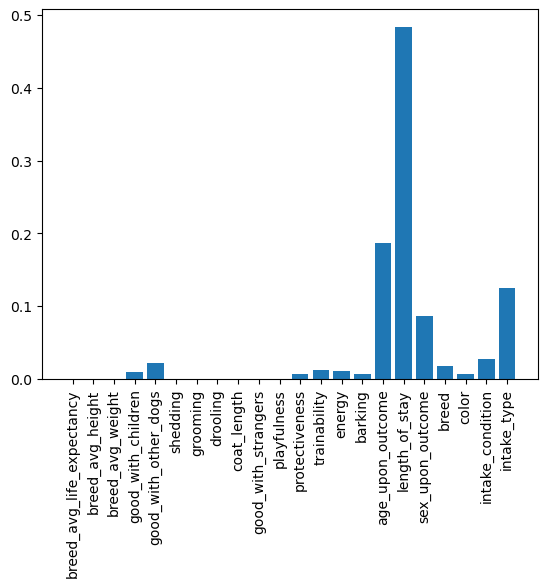

In [42]:
plt.bar(columns, best_tree_clf.feature_importances_)
plt.xticks(rotation = 'vertical')
plt.show()

How can be noticed from the plot above most of the considered features don't contribute to the classification purpose. For this reason we can think about considering only the top $5$ most important features and redo again parameter choice, training and test.

In [43]:
columns2keep

['age_upon_outcome',
 'length_of_stay',
 'sex_upon_outcome',
 'intake_condition',
 'intake_type']

So we do again the hyper-parameters search:

In [44]:
param_distr = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None],
    'min_samples_split': [2, 5, 10, 20, 50], 
    'min_samples_leaf': [1, 3, 5, 10, 20], 
    'min_impurity_decrease': [0.0, 0.001, 0.01, 0.1, 0.2],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.1, 0.2, 1],
}

tree_clf = DecisionTreeClassifier(random_state=0)

rs = RandomizedSearchCV(tree_clf, param_distributions=param_distr, cv=10, 
                        n_iter=250,
                        scoring='f1_micro',
                        n_jobs=8
                       )
rs.fit(X2k_train, y_train)

RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=0),
                   n_iter=250, n_jobs=8,
                   param_distributions={'ccp_alpha': [0.0, 0.001, 0.01, 0.1,
                                                      0.2, 1],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, None],
                                        'min_impurity_decrease': [0.0, 0.001,
                                                                  0.01, 0.1,
                                                                  0.2],
                                        'min_samples_leaf': [1, 3, 5, 10, 20],
                                        'min_samples_split': [2, 5, 10, 20,
                                                              50]},
                   scoring='f1_micro')

These are the new 'best' values among the one explored:

In [45]:
best_tree_clf = rs.best_estimator_
rs.best_params_

{'min_samples_split': 5,
 'min_samples_leaf': 10,
 'min_impurity_decrease': 0.001,
 'max_depth': None,
 'criterion': 'gini',
 'ccp_alpha': 0.001}

And the corresponding `classification_report` is:

In [46]:
y_pred_tree = best_tree_clf.predict(X2k_test)
print(classification_report(y_test, y_pred_tree, digits=4))

              precision    recall  f1-score   support

           0     0.7610    0.9250    0.8350       840
           1     0.7399    0.5978    0.6613       276
           2     0.7778    0.2349    0.3608       149
           3     0.7917    0.3958    0.5278        48

    accuracy                         0.7586      1313
   macro avg     0.7676    0.5384    0.5962      1313
weighted avg     0.7596    0.7586    0.7335      1313



The results are better than before: accuracy have increased and also the recall have increased for both class $2$ and $3$. Nonetheless the results especially for class $2$ are not exciting.

The corresponding confusion matrix looks like:

In [47]:
cm_tree = confusion_matrix(y_test, y_pred_tree)
cm_tree

array([[777,  52,   9,   2],
       [111, 165,   0,   0],
       [106,   5,  35,   3],
       [ 27,   1,   1,  19]], dtype=int64)

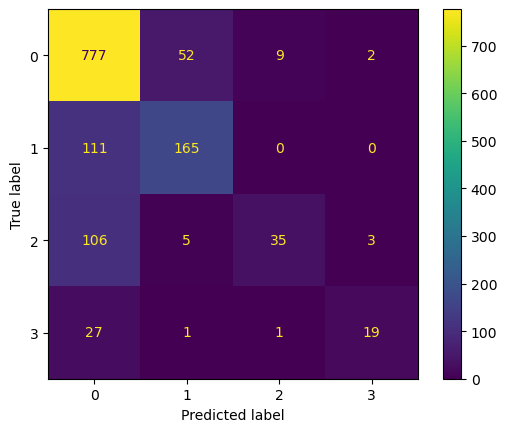

In [48]:
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree)
disp_tree.plot()
plt.show()

As expected (because of the low recall) there is an high number of false negatives both for class $2$ and class $3$.

The top part of the tree now looks like this:

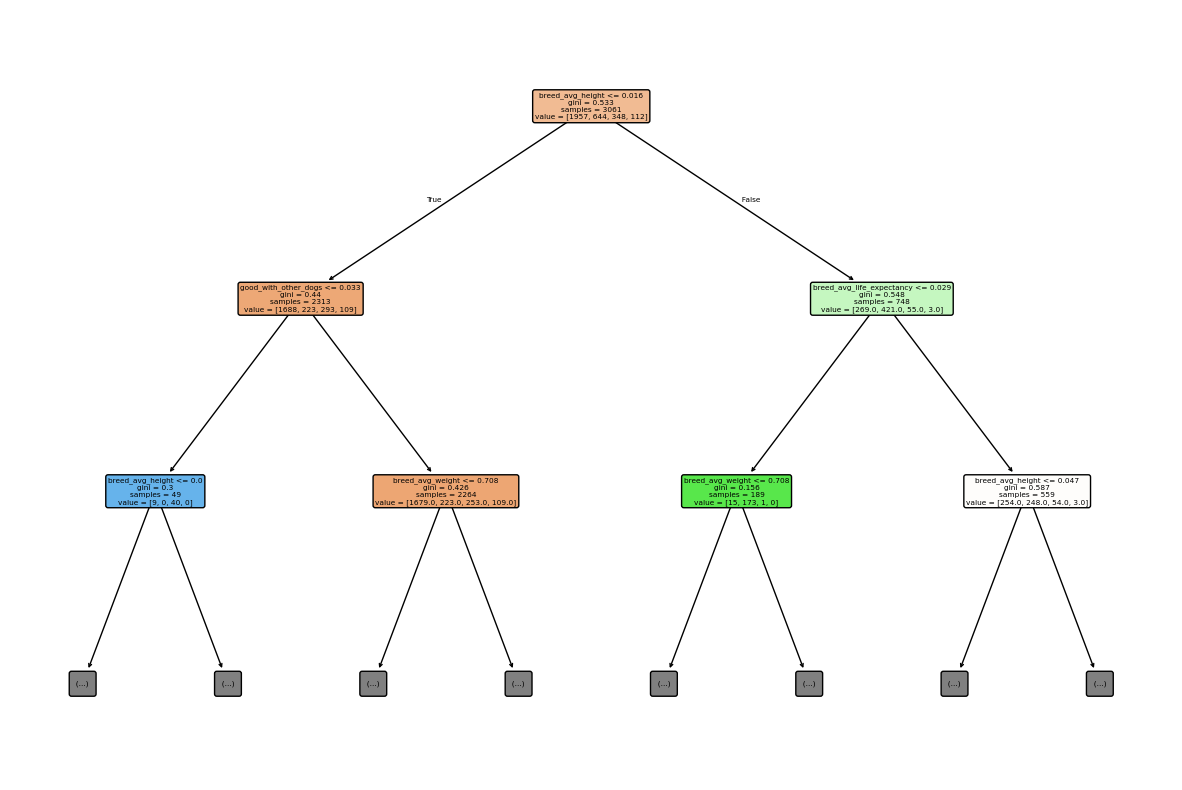

In [49]:
plt.figure(figsize=(15, 10))
plot_tree(best_tree_clf, feature_names=columns, 
          filled=True, rounded=True, impurity=True, max_depth=2
         )
plt.show()

Obviously all the features considered now are important:

In [50]:
best_tree_clf.feature_importances_

array([0.20142477, 0.51692028, 0.09687377, 0.05523253, 0.12954865])

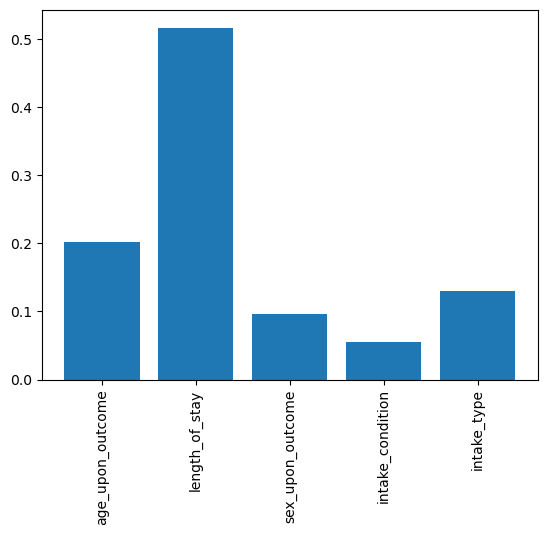

In [51]:
plt.bar(columns2keep, best_tree_clf.feature_importances_)
plt.xticks(rotation = 'vertical')
plt.show()

## KNN
- find the best k parameter and the best distance. show how performance varies depending on k
- evaluate the performance of your best model using the correct plots

Also in the KNN case the hyper-parameter choice can be done manually by sseing for which value of $k$ (number of neighbors) we obtain a better `cross_validation_score` with respect to the scoring 'f1_micro' (whose choice has already been explained in the section above).

Since KNN suffers the curse of dimensionality, we can exploit the results of the previous section and consider only the most important features (found by using `feature_importances_` in the section above):

In [52]:
k_list = np.arange(1,40,2)

scores_list = list()
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    scores = cross_val_score(knn, X2k_train, y_train, cv=10, scoring='f1_micro')
    scores_list.append(scores)
    
scores_list = np.array(scores_list)

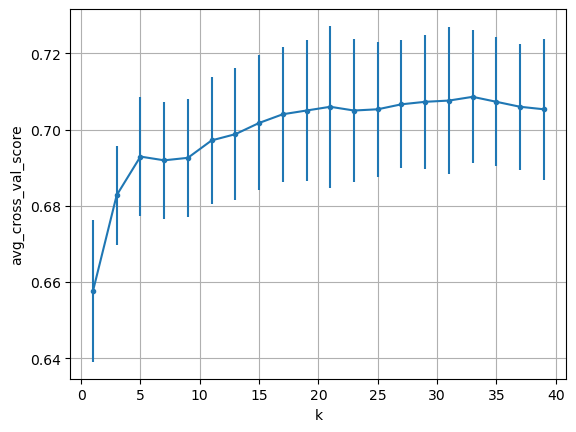

In [53]:
plt.errorbar(k_list, np.mean(scores_list, axis = 1), yerr=np.std(scores_list, axis=1), marker='.')
plt.xlabel('k')
plt.ylabel('avg_cross_val_score')
plt.grid()
plt.show()

In this case the best value for $k$ seems to be $k = 25$.

A better way to explore the hyper-parameter space is that of automatize the sarch by using `GridSearchCV`:

In [54]:
param_grid = {
    'n_neighbors' : np.arange(1,41),
    'weights' : ['uniform', 'distance']
}

knn_clf = KNeighborsClassifier()

rs = GridSearchCV(knn_clf, param_grid=param_grid, cv=10, 
                        scoring='f1_micro',
                        n_jobs=8
                       )
rs.fit(X2k_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=8,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40]),
                         'weights': ['uniform', 'distance']},
             scoring='f1_micro')

The best parameter choice is:

In [55]:
best_knn_clf = rs.best_estimator_
rs.best_params_


{'n_neighbors': 25, 'weights': 'uniform'}

And the `classification_report` gives:

In [56]:
y_pred_knn = best_knn_clf.predict(X2k_test)
print(classification_report(y_test, y_pred_knn, digits=4))

              precision    recall  f1-score   support

           0     0.7090    0.9571    0.8146       840
           1     0.8299    0.4420    0.5768       276
           2     0.5625    0.1208    0.1989       149
           3     0.0000    0.0000    0.0000        48

    accuracy                         0.7190      1313
   macro avg     0.5254    0.3800    0.3976      1313
weighted avg     0.6919    0.7190    0.6650      1313



c:\Users\gioel\anaconda3\envs\env_master_2025\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gioel\anaconda3\envs\env_master_2025\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gioel\anaconda3\envs\env_master_2025\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In this case the result are very bad. The accuracy is better than that of the Dummy classifier but the class $3$ is never recognized.

In this case the confusion matrix looks like this: 

In [57]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_knn

array([[804,  25,  11,   0],
       [152, 122,   2,   0],
       [131,   0,  18,   0],
       [ 47,   0,   1,   0]], dtype=int64)

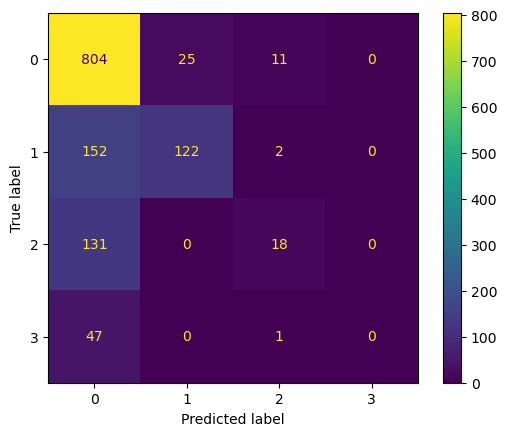

In [58]:
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn)
disp_knn.plot()
plt.show()

As expected (because of the low recall) there is an high number of false negatives both for class $2$ and class $3$.

## Random Forest
- find the best parameters
- evaluate model performance
- (optional) find the most important features (`clf.feature_importances_`)

Let's now work with the Random Forest classifier

The hyper-parameter choice also in this case is perfomed by using the `RandomizedSearchCV`:

In [59]:
columns2keep

['age_upon_outcome',
 'length_of_stay',
 'sex_upon_outcome',
 'intake_condition',
 'intake_type']

In [60]:
param_distr = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None],
    'min_samples_split': [2, 5, 10, 20, 50], 
    'min_samples_leaf': [1, 3, 5, 10, 20], 
    'min_impurity_decrease': [0.0, 0.001, 0.01, 0.1, 0.2],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.1, 0.2, 1],
}

forest_clf = RandomForestClassifier(n_estimators=100, # number of bootstrapped samples
                            max_features= 'sqrt', # Number of feature in each sample
                            random_state=0,
                            n_jobs=8
                           )

rs = RandomizedSearchCV(forest_clf, param_distributions=param_distr, cv=10, 
                        n_iter=200,
                        scoring='f1_micro',
                        n_jobs=8
                       )
rs.fit(X2k_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(n_jobs=8, random_state=0),
                   n_iter=200, n_jobs=8,
                   param_distributions={'ccp_alpha': [0.0, 0.001, 0.01, 0.1,
                                                      0.2, 1],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, None],
                                        'min_impurity_decrease': [0.0, 0.001,
                                                                  0.01, 0.1,
                                                                  0.2],
                                        'min_samples_leaf': [1, 3, 5, 10, 20],
                                        'min_samples_split': [2, 5, 10, 20,
                                                              50]},
                   scoring='f1_micro')

The following is the best estimator and the corresponding best parameters as found by the `RandomizedSearchCV`:

In [61]:
best_forest_clf = rs.best_estimator_
rs.best_params_

{'min_samples_split': 20,
 'min_samples_leaf': 3,
 'min_impurity_decrease': 0.0,
 'max_depth': 10,
 'criterion': 'gini',
 'ccp_alpha': 0.001}

The `classification_report` of the best estimator looks like this:

In [62]:
y_pred_forest = best_forest_clf.predict(X2k_test)
print(classification_report(y_test, y_pred_forest, digits = 4))

              precision    recall  f1-score   support

           0     0.7607    0.9536    0.8463       840
           1     0.8163    0.5797    0.6780       276
           2     0.8140    0.2349    0.3646       149
           3     0.8095    0.3542    0.4928        48

    accuracy                         0.7715      1313
   macro avg     0.8001    0.5306    0.5954      1313
weighted avg     0.7802    0.7715    0.7433      1313



The results are comparable to the ones obtained by using the Decision Tree classifier.

And having a look at the confusion matrix:

In [63]:
cm_forest = confusion_matrix(y_test, y_pred_forest)
cm_forest

array([[801,  31,   6,   2],
       [116, 160,   0,   0],
       [108,   4,  35,   2],
       [ 28,   1,   2,  17]], dtype=int64)

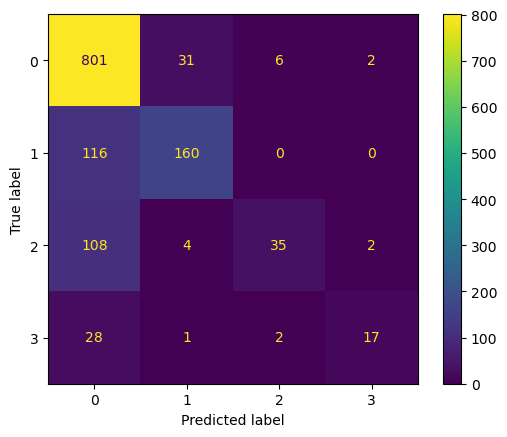

In [64]:
disp_forest = ConfusionMatrixDisplay(confusion_matrix=cm_forest)
disp_forest.plot()
plt.show()

As already said the results are comparable with that of the Decision Tree. The class $2$ remains the most difficult to correctly classify.

## SVM
- find the best parameters
- evaluate the model

In [65]:
from sklearn.svm import LinearSVC, SVC

In this section both the linear and the non linear support vector machine classifier will be used.

Let's start with the linear one

The fastest way to determine the best choice of hyper-parameters is in this case `GridSearchCV`:

In [66]:
param_grid = {
    'C' : np.arange(0.01, 5., 0.1),
}

lsvc_clf = LinearSVC()

rs = GridSearchCV(lsvc_clf, param_grid=param_grid, cv=10, 
                        scoring='f1_micro',
                        n_jobs=8
                       )
rs.fit(X2k_train, y_train)

GridSearchCV(cv=10, estimator=LinearSVC(), n_jobs=8,
             param_grid={'C': array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1.01,
       1.11, 1.21, 1.31, 1.41, 1.51, 1.61, 1.71, 1.81, 1.91, 2.01, 2.11,
       2.21, 2.31, 2.41, 2.51, 2.61, 2.71, 2.81, 2.91, 3.01, 3.11, 3.21,
       3.31, 3.41, 3.51, 3.61, 3.71, 3.81, 3.91, 4.01, 4.11, 4.21, 4.31,
       4.41, 4.51, 4.61, 4.71, 4.81, 4.91])},
             scoring='f1_micro')

The best value for the hyper-parameter `C` is the following:

In [67]:
best_lsvc_clf = rs.best_estimator_
rs.best_params_

{'C': 4.01}

The corresponding `classification_report` gives us:

In [68]:
y_pred_lsvc = best_lsvc_clf.predict(X2k_test)
print(classification_report(y_test, y_pred_lsvc, digits = 4))

              precision    recall  f1-score   support

           0     0.6868    0.9631    0.8018       840
           1     0.7565    0.3152    0.4450       276
           2     0.5000    0.0671    0.1183       149
           3     0.0000    0.0000    0.0000        48

    accuracy                         0.6900      1313
   macro avg     0.4858    0.3364    0.3413      1313
weighted avg     0.6551    0.6900    0.6199      1313



c:\Users\gioel\anaconda3\envs\env_master_2025\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gioel\anaconda3\envs\env_master_2025\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gioel\anaconda3\envs\env_master_2025\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

The results are pretty bad compared to all of the above classifiers.

Let's have look at the confusion matrix 

In [69]:
cm_lsvc = confusion_matrix(y_test, y_pred_lsvc)
cm_lsvc

array([[809,  24,   7,   0],
       [186,  87,   3,   0],
       [136,   3,  10,   0],
       [ 47,   1,   0,   0]], dtype=int64)

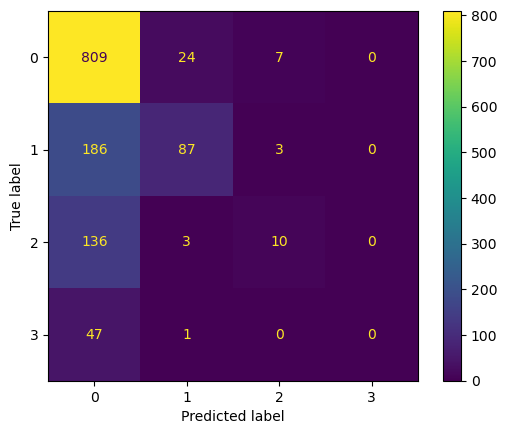

In [70]:
disp_lsvc = ConfusionMatrixDisplay(confusion_matrix=cm_lsvc)
disp_lsvc.plot()
plt.show()

Linear SVC performs a little better than the Dummy classifier but still quite badly. It does never recognize class $3$ and the recall for class $2$ is very low.

Let's see if better results are achieved by using a non linear SVC.

The hyper-parameters are chosen according to the results of the `RandomizedSearchCV`. Here also the `kernel` has to be specified in order to perform the 'kernel trick':

In [71]:
param_distr = {
    'C' : np.arange(0.01,5., 0.5),
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']
}

svc_clf = SVC()

rs = RandomizedSearchCV(svc_clf, param_distributions=param_distr, cv=10, n_iter=35,
                        scoring='f1_micro',
                        n_jobs=8
                       )
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=SVC(), n_iter=35, n_jobs=8,
                   param_distributions={'C': array([0.01, 0.51, 1.01, 1.51, 2.01, 2.51, 3.01, 3.51, 4.01, 4.51]),
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   scoring='f1_micro')

In this non linar case for SVC seems that the `RandomizedSearchCV` have more difficulty dealing with `X2k` than with `X` (which has more attribute). So let's stick with `X` in order to obtain faster results.

The 'best' parameter choice in this case is:

In [72]:
best_svc_clf = rs.best_estimator_
rs.best_params_

{'kernel': 'poly', 'C': 1.01}

And the `classification_report` looks like this:

In [73]:
y_pred_svc = best_svc_clf.predict(X_test)
print(classification_report(y_test, y_pred_svc, digits = 4))

              precision    recall  f1-score   support

           0     0.6952    0.9476    0.8020       840
           1     0.7379    0.3877    0.5083       276
           2     0.6957    0.1074    0.1860       149
           3     0.0000    0.0000    0.0000        48

    accuracy                         0.6999      1313
   macro avg     0.5322    0.3607    0.3741      1313
weighted avg     0.6788    0.6999    0.6411      1313



c:\Users\gioel\anaconda3\envs\env_master_2025\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gioel\anaconda3\envs\env_master_2025\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gioel\anaconda3\envs\env_master_2025\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

The results are better than the linear SVC but still worse than all the other classifiers above.

And the confusion matrix looks like:

In [74]:
cm_svc = confusion_matrix(y_test, y_pred_svc)
cm_svc

array([[796,  37,   7,   0],
       [169, 107,   0,   0],
       [132,   1,  16,   0],
       [ 48,   0,   0,   0]], dtype=int64)

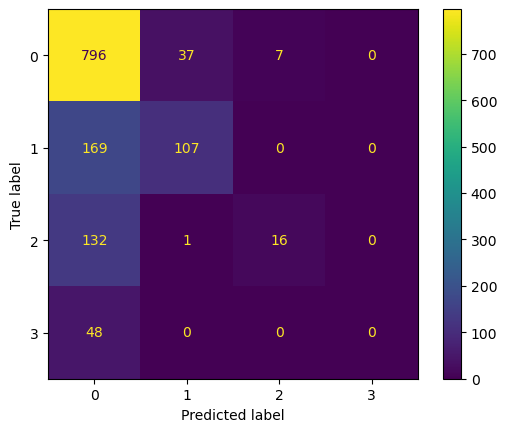

In [75]:
disp_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc)
disp_svc.plot()
plt.show()

Again, in the non linear case the result are a little bit better than the linear one but still quite bad compared to how the Dummy classifier performs.

## Wrap Up
- comment on your findings:
    - which model performed best?
    - which are the most important features?
    - which are the most difficult classes to predict?
- can you say something about the outcome of a dog?

Let's sum up the results:

- The best classification models were the Decision Tree and the Random Forest. The worst models are the KNN and the SVM (especially the linear one which is absolutely the worst);
- The most important feature (as returned by the `feature_importances_` attribute of the Decision Tree classifier) are `sex_upon_outcome`, `age_upon_outcome`, `intake_condition`, `intake_type` and `length_of_stay`;
- The most difficult classes to predict are the $2$ and the $3$ (which have low recall).

Unfortunately we can't say much about the outcome of the dog. No model has extremely good performance and therefore the classification is not particularly reliable. Since class $0$ is the better predicted class, at most one can use these models to predict if a dog belongs or not to such class.